# Introduction

**Goal:** 

To predict the selling prices of houses in King County, WA. using Multiple Linear Regression to determine what are the important factors to consider when determining the price of a house, and provide recommendations and intuition for those aiming to sell their homes.

**Methodology:**

We are using the OSEMN Process:
- **Obtain**: Since our dataset is handed to us, we don't have to jump through any hoops and can load in the dataset.

- **Scrub**: This is where we clean the data. In this section, we will be looking for: outliers, null values, and viewing the types of values within each column.

- **Explore**: Looking at our data and the relationship between variables, along with more cleaning aspects like: normalizing and scaling, one hot encoding, and looking for multicollinearity.

- **Model**: We will then create linear regression models to determine which factors play a significant role when determining the selling price of a house.

- **Interpret**: Results and Conclusion.

# Step 1: Obtaining the Data

Our data was given to us in a nice csv.file, so we simply load it in.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_columns', 0)
plt.style.use('seaborn')

kc_df_raw = pd.read_csv('kc_house_data.csv')

In [2]:
kc_df_raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Step 2: Scrub

- We take a look at the types of values within each column. 
- We recast certain columns to different types.
- We look for and remove any null/NaN values.
- We create new columns to use for our models.
- Drop any columns we feel are not necessary for our model.
- Filter our dataframe to remove major outliers.


In [3]:
kc_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


### Column Descriptions:
* **id** - unique identified for a house
* **date** - house was sold
* **price** -  is prediction target
* **bedrooms** -  of Bedrooms/House
* **bathrooms** -  of bathrooms/bedrooms
* **sqft_living** -  footage of the home
* **sqft_lot** -  footage of the lot
* **floors** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

### 'bath_per_bed' column

we create this column to view the ratio of baths per bed of each house within our dataset.

### 'renovated' column
we create this column to replace 'yr_renovated' and make it a column consisting of 0's and 1's indicating if the house was renovated. We will later on use this as a categorical column.

### 'has_basement' column
We create this columnn to replace 'sqft_basement' and also make this column consisting of boolean values to determine if the house has a basement.

### 'subregion' Column

We create this column by finding the subregions for groups of zipcodes on a website (can be found here: http://www.agingkingcounty.org/wp-content/uploads/sites/185/2016/09/SubRegZipCityNeighborhood.pdf). I manually create a dictionary, and then use that dictionary to create a new column in our Dataframe that determines the subregion for each house based on it's zipcode. This column will be used later on as a categorical column.

## Setting the filters for our dataset

I created a function that pulls the 1st and 99th quantiles of every column and prints out the column name along with the number of values within the range of the quantiles and the number of outliers outside the range.

Since **'sqft_lot'** would only drop 7 rows for cutting off extreme outliers, we **filter our dataset** by cutting off those houses outside the **1st and 99th quantiles** of our **'sqft_lot'** column.

# Step 3 - Exploring Our Data

In [4]:
#Loading in our cleaned dataframe - we used pickle to maintain the changed types of columns
with open('kc_housing.pickle', 'rb') as f:
    kc_clean = pickle.load(f)

### We remove any columns we don't need for our model

In [5]:
kc_clean.drop(['sqft_basement', 'lat', 'long', 'month'], axis=1, inplace=True)

### Viewing all continuous columns and their relationship with Price

We begin by running a **for** loop for each chosen continuous column within our dataframe and comparing it with price in a sns.regplot() to determine which columns we will want to inspect further and which we can throw away. We also create a  dataframe of df.corr() by comparing each column to price, and then sort those values from highest to lowest. This gives us a rough idea of which values could be significant when determining the price of a house.

In [6]:
cont_vars = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 
            'sqft_above', 'sqft_living15', 'sqft_lot15', 'bath_per_bed', 'house_age']

### Question 1:
**What variables are linearly related to price?**

This would give us insight on which columns to explore more and keep as predictor variables for our model

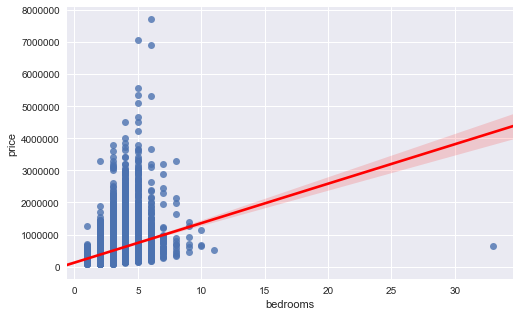

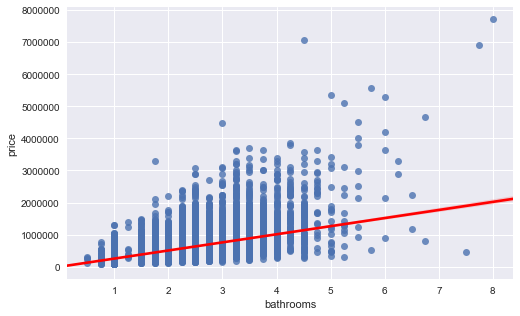

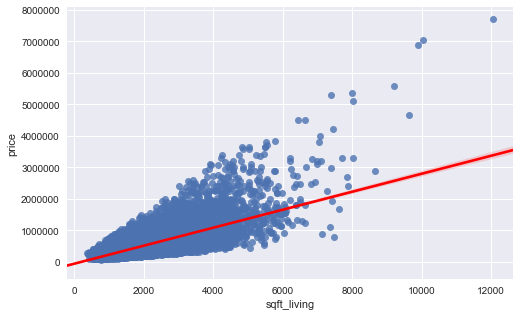

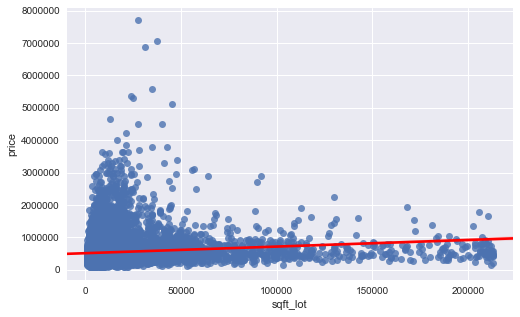

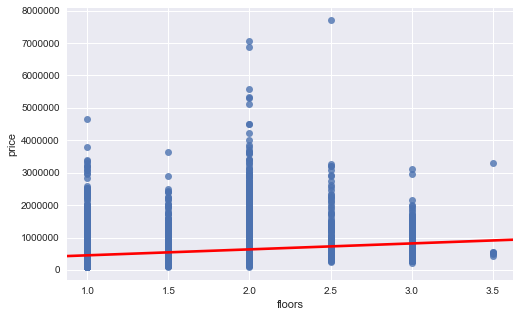

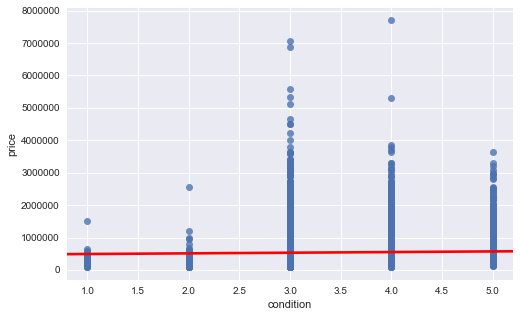

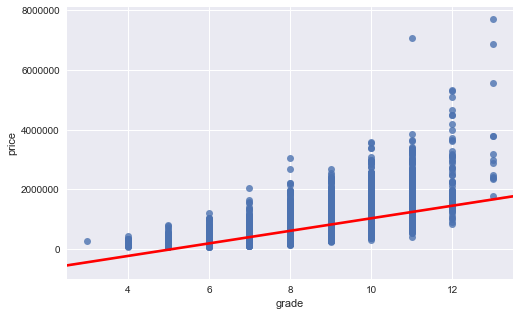

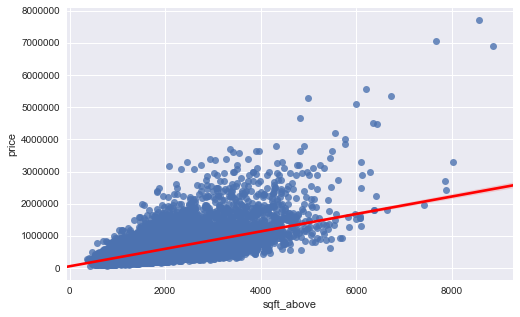

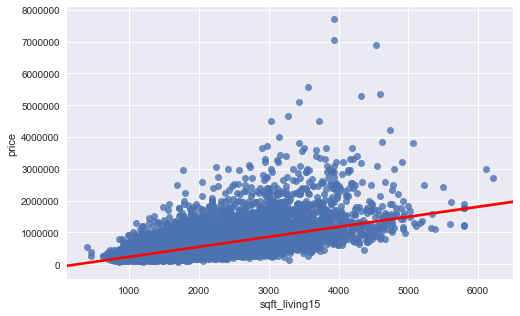

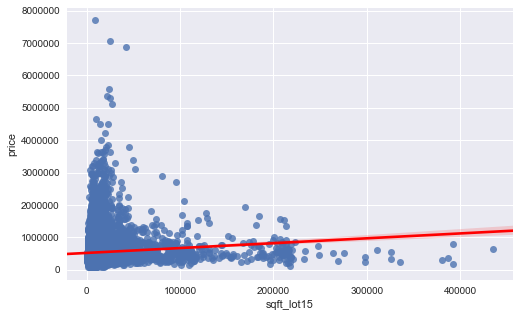

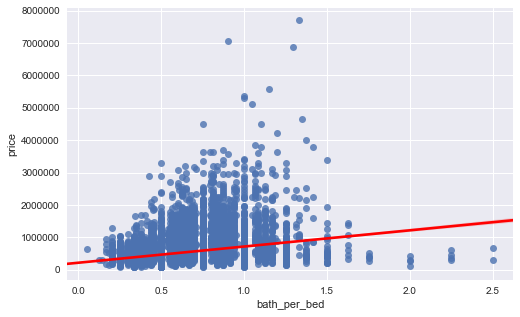

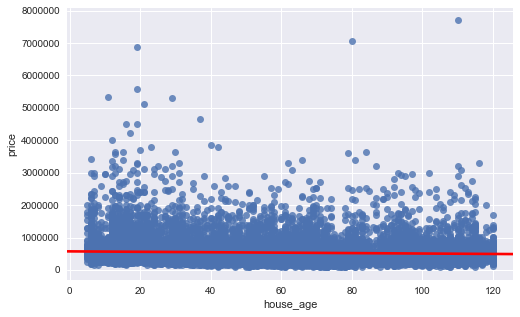

In [7]:
for col in kc_clean[cont_vars]:
    plt.figure(figsize=(8,5))
    sns.regplot(data=kc_clean, x=col, y='price', line_kws={'color': 'red'})

In [8]:
pd.DataFrame(kc_clean.corr()['price']).sort_values(by='price',ascending=False)

,price
price,1.000000
sqft_living,0.701991
grade,0.666973
sqft_above,0.602473
sqft_living15,0.584590
price_per_sqft,0.563504
bathrooms,0.523608
view,0.357022
bedrooms,0.307952
bath_per_bed,0.283479


### Answer for Question 1:
- these scatterplots and correlation for each continuous variable when compared to price show us which are linearly related to price.
- It also gives us a good indication as to which aspects of a house we want to focus on for our models.

### Separating Our cleaned dataframe into two different dataframes: Continuous and Categorical Variables.

Within this dataframe, we have all of our **numerical** columns we want to inspect and are going to **normalize (if needed) and scale using the z-score method.** 

**The numerical columns are**: 
- 'sqft_above'
- 'sqft_living'
- sqft_living15'
- 'sqft_lot'
- 'sqft_lot15'
- 'bedrooms'
- 'bathrooms'
- 'floors'
- 'grade'
- 'condition'
- 'house_age'
- 'bath_per_bed'
- 'price'


In [9]:
kc_continuous = ['sqft_above', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 
                 'bedrooms', 'bathrooms', 'floors', 'grade', 'condition', 'house_age', 'bath_per_bed', 'price']
kc_categorical = ['waterfront', 'renovated', 'view', 'zipcode', 'has_basement']
cont_df = kc_clean[kc_continuous]
cat_df = kc_clean[kc_categorical]

### Normalizing (if needed) and Scaling Our Continuous Data

First, we take a look at the distribution of each column in our dataframe to determine whether or not we should normalize the data:

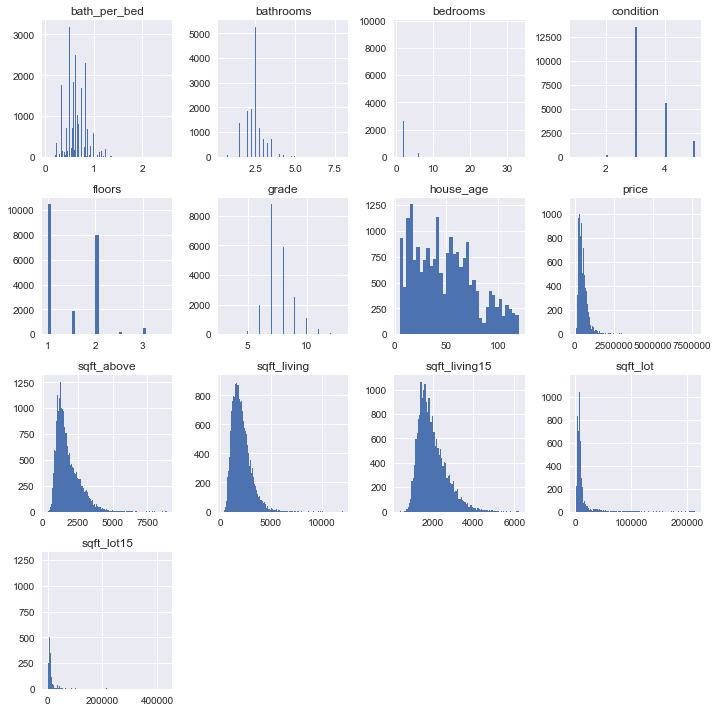

In [10]:
with plt.style.context('seaborn'):
    cont_df.hist(figsize=(10,10), bins='auto')
    plt.tight_layout();

Selecting the columns we need to be normalized:

In [11]:
selected_log_cols = ['price', 'sqft_above', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']

Next, we log the chosen columns, and add them to our dataframe.

In [12]:
for col in selected_log_cols:
    cont_df[f'{col}_log'] = cont_df[col].map(lambda x: np.log(x))

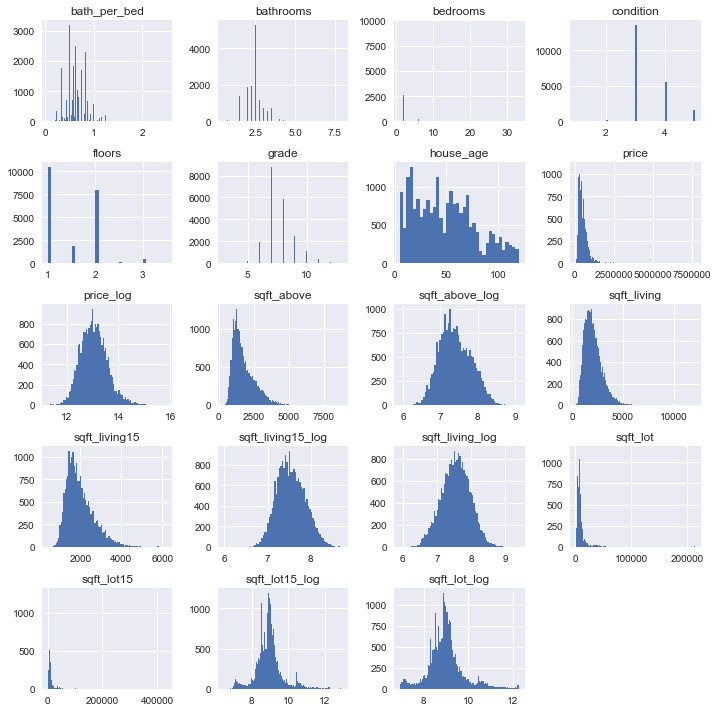

In [13]:
with plt.style.context('seaborn'):
    cont_df.hist(figsize=(10,10), bins='auto')
    plt.tight_layout();

Next, we grab the selected columns that have been normalized (and ones that were already normal) and put them into a new dataframe to use. 

In [14]:
select_df = cont_df[['price_log', 'sqft_above_log', 'sqft_living_log', 
                     'sqft_living15_log', 'sqft_lot_log','sqft_lot15_log', 'bedrooms', 'bathrooms', 'bath_per_bed', 
                     'floors', 'grade', 'condition', 'house_age']]
                       

From here, we define a function to z-score the columns using **StandardScaler**:

In [15]:
def zscore(df):
    """
    Definition:
    Uses the StandardScaler() class from sklearn.preprocessing to scale numerical data of the 
    selected dataframe by z-scoring the data.
    
    Args:
    df = chosen dataframe. Must have all numerical values.
    
    Returns:
    a dataframe containing the scaled data    
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.values)
    print(scaled_data.shape)
    select_scaled = pd.DataFrame(data=scaled_data, index=df.index, columns=df.columns)
    return select_scaled

In [16]:
select_scaled_df = zscore(select_df)

(20995, 13)


We add price back into the dataframe

In [17]:
select_scaled_df['price'] = kc_clean['price']

In [18]:
select_scaled_df.describe()

,price_log,sqft_above_log,sqft_living_log,sqft_living15_log,sqft_lot_log,sqft_lot15_log,bedrooms,bathrooms,bath_per_bed,floors,grade,condition,house_age,price
count,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,20995.000000,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04
mean,1.434961e-16,-1.765273e-15,-4.331959e-16,8.447319e-16,-1.451206e-15,3.682165e-16,-1.204826e-16,-4.331959e-17,8.663917e-17,0.000000,1.028840e-16,-4.331959e-17,2.165979e-17,5.403582e+05
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024,1.000024e+00,1.000024e+00,1.000024e+00,3.689172e+05
min,-3.376132e+00,-3.490173e+00,-3.886682e+00,-4.754174e+00,-2.548468e+00,-3.308065e+00,-2.577353e+00,-2.104856e+00,-2.797676e+00,-0.912126,-3.978142e+00,-3.703696e+00,-1.513924e+00,7.800000e+04
25%,-7.031571e-01,-7.216539e-01,-6.820303e-01,-7.209081e-01,-5.451191e-01,-5.482791e-01,-4.132815e-01,-4.743437e-01,-6.597818e-01,-0.912126,-5.591049e-01,-6.379692e-01,-8.660575e-01,3.200000e+05
50%,-5.759156e-02,-8.926629e-02,1.641963e-02,-5.844825e-02,-4.764336e-02,-1.620418e-02,-4.132815e-01,1.778614e-01,-6.189610e-02,0.027433,-5.591049e-01,-6.379692e-01,-1.158966e-01,4.500000e+05
75%,6.240959e-01,7.152760e-01,6.890731e-01,6.998093e-01,3.562867e-01,3.499212e-01,6.687543e-01,5.039639e-01,5.359896e-01,0.966991,2.956543e-01,8.948945e-01,6.683625e-01,6.450000e+05
max,5.319609e+00,3.982592e+00,4.370288e+00,3.648516e+00,4.082217e+00,5.395171e+00,3.204779e+01,7.678220e+00,8.906389e+00,3.785666,4.569450e+00,2.427758e+00,2.407372e+00,7.700000e+06


While there are outliers within this dataframe, we will one-hot-encode the categorical dataframe and join it before removing those outliers.

In [19]:
cat_df = pd.get_dummies(cat_df, drop_first=True)

In [20]:
cat_df.head()

,waterfront,renovated,view,has_basement,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7129300520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6414100192,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5631500400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2487200875,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1954400510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
merge_selected = pd.concat([select_scaled_df, cat_df], axis=1)

In [22]:
merge_selected.describe()

,price_log,sqft_above_log,sqft_living_log,sqft_living15_log,sqft_lot_log,sqft_lot15_log,bedrooms,bathrooms,bath_per_bed,floors,grade,condition,house_age,price,waterfront,renovated,view,has_basement,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,...,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,20995.000000,2.099500e+04,2.099500e+04,2.099500e+04,2.099500e+04,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,...,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000,20995.000000
mean,1.434961e-16,-1.765273e-15,-4.331959e-16,8.447319e-16,-1.451206e-15,3.682165e-16,-1.204826e-16,-4.331959e-17,8.663917e-17,0.000000,1.028840e-16,-4.331959e-17,2.165979e-17,5.403582e+05,0.006906,0.034865,0.097738,0.392522,0.009383,0.013146,0.014956,0.008002,0.023339,0.006621,0.013479,0.004382,0.009240,0.005096,0.008383,0.009859,0.023434,0.003144,0.018052,0.013432,0.015051,0.012003,0.012908,0.005859,0.020529,0.025816,...,0.012384,0.019243,0.021196,0.022005,0.014289,0.004811,0.012908,0.020624,0.016956,0.008764,0.015909,0.004620,0.027102,0.010764,0.015099,0.012241,0.008764,0.004954,0.012336,0.027149,0.014956,0.025768,0.023482,0.008288,0.013146,0.018957,0.016575,0.022529,0.011860,0.015289,0.013384,0.002667,0.021005,0.011908,0.012574,0.012098,0.012289,0.006430,0.013098,0.014813
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024,1.000024e+00,1.000024e+00,1.000024e+00,3.689172e+05,0.082819,0.183443,0.296967,0.488324,0.096414,0.113903,0.121379,0.089097,0.150981,0.081099,0.115318,0.066053,0.095684,0.071209,0.091176,0.098807,0.151281,0.055981,0.133142,0.115117,0.121759,0.108901,0.112880,0.076318,0.141803,0.158589,...,0.110594,0.137380,0.144039,0.146704,0.118683,0.069194,0.112880,0.142125,0.129111,0.093207,0.125125,0.067816,0.162384,0.103194,0.121949,0.109962,0.093207,0.070209,0.110384,0.162522,0.121379,0.158446,0.151431,0.090661,0.113903,0.136376,0.127677,0.148400,0.108258,0.122704,0.114916,0.051578,0.143404,0.108473,0.111431,0.109327,0.110174,0.079932,0.113699,0.120807
min,-3.376132e+00,-3.490173e+00,-3.886682e+00,-4.754174e+00,-2.548468e+00,-3.308065e+00,-2.577353e+00,-2.104856e+00,-2.797676e+00,-0.912126,-3.978142e+00,-3.703696e+00,-1.513924e+00,7.800000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

### Now that we have combined our zipcode dataframe, we can remove any scaled outliers by selecting the rows of numerical columns that are within 3 standard deviations of the mean for each column:

In [23]:
num_cols = merge_selected.drop('price', axis=1).columns

for col in num_cols:
    merge_selected = merge_selected.loc[merge_selected[f'{col}'] <= 3]
    merge_selected = merge_selected.loc[merge_selected[f'{col}'] >= -3]

In [24]:
zipcode_model = merge_selected

### We run through the same process with our Subregion Dataframe

In [25]:
#loading in the subregion dataframe from our notebook
subregion_model = pd.read_csv('subregion_df.csv')

In [26]:
subregion_model.head()

,id,price_log,sqft_above_log,sqft_living_log,sqft_living15_log,sqft_lot_log,sqft_lot15_log,bedrooms,bathrooms,bath_per_bed,floors,grade,condition,house_age,price,lat,long,waterfront,renovated,view,has_basement,subregion_east_urban,subregion_north,subregion_north_and_seattle,subregion_seattle,subregion_south_and_seattle,subregion_south_rural,subregion_south_urban,subregion_vashon_island
0,7129300520,-1.396379,-0.761202,-1.137533,-1.045715,-0.417664,-0.416471,-0.413282,-1.452651,-1.456963,-0.912126,-0.559105,-0.637969,0.531970,221900.0,47.5112,-122.257,0,0,0,0,0,0,0,0,0,0,1,0
1,6414100192,0.280619,0.672297,0.707592,-0.335350,-0.109907,-0.012872,-0.413282,0.177861,0.535990,0.966991,-0.559105,-0.637969,0.668363,538000.0,47.7210,-122.319,0,1,0,1,0,0,0,1,0,0,0,0
2,5631500400,-1.792645,-1.765663,-2.149421,1.121457,0.290145,0.059247,-1.495317,-1.452651,-0.659782,-0.912126,-1.413864,-0.637969,1.282131,180000.0,47.7379,-122.233,0,0,0,0,0,1,0,0,0,0,0,0
3,2487200875,0.499734,-1.035858,0.065296,-1.000364,-0.569183,-0.580015,0.668754,1.156169,0.535990,-0.912126,-0.559105,2.427758,0.190987,604000.0,47.5208,-122.393,0,0,0,1,0,0,0,1,0,0,0,0
4,1954400510,0.179413,0.070077,-0.300108,-0.142320,0.025839,-0.036910,-0.413282,-0.148241,0.137399,-0.912126,0.295654,-0.637969,-0.559174,510000.0,47.6168,-122.045,0,0,0,0,1,0,0,0,0,0,0,0


### Our next step is to remove any columns that have a high collinearity with another column other than price_log (and price).

We do this by running our dataframes through a heat correlation map function:

In [27]:
def heat_collinearity(corr, figsize=(8, 8)):
    """
    Definition:
    Shows the bottom triangle of a heat correlation
    
    Args:
    corr = corr() function - usually obtained from the outside function heat_corr()
    figsize = default = (12,12)
    
    Returns:
    A heat map
    """
    fig, ax = plt.subplots(figsize=figsize)
    mask = np.zeros_like(corr, dtype=np.bool)
    idx = np.triu_indices_from(mask)
    mask[idx] = True
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, square=True, mask=mask, cmap='Reds', ax=ax)
    ax.set_ylim(len(corr.columns), 0);
    return fig, ax

In [28]:
def heat_corr(df, target_cols, figsize=(8, 8)):
    """
    Definition:
    Creates a corr() of a dataframe and places the corr() within the heat_collinearity() function.
    If the amount of columns is > 50, figsize will change into (50,50)
    
    Args:
    df = selected dataframe
    target_cols = all continuous variables you wish to correlate
    figsize = default is (12,12)
    
    Returns:
    A heat map
    """
    corr = abs(df[target_cols].corr().round(2))
    if len(target_cols) > 50:
        heat_collinearity(corr, figsize=(50,50))
    else:
        heat_collinearity(corr, figsize=(12,12))

In [29]:
zipcode_model.head(1)

,price_log,sqft_above_log,sqft_living_log,sqft_living15_log,sqft_lot_log,sqft_lot15_log,bedrooms,bathrooms,bath_per_bed,floors,grade,condition,house_age,price,waterfront,renovated,view,has_basement,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,...,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7129300520,-1.396379,-0.761202,-1.137533,-1.045715,-0.417664,-0.416471,-0.413282,-1.452651,-1.456963,-0.912126,-0.559105,-0.637969,0.53197,221900.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [30]:
#Making a list of all continuous columns within our dataframe to use in our heat_corr function
cont_vars = list(zipcode_model.columns[:13])
cont_vars

['price_log',
 'sqft_above_log',
 'sqft_living_log',
 'sqft_living15_log',
 'sqft_lot_log',
 'sqft_lot15_log',
 'bedrooms',
 'bathrooms',
 'bath_per_bed',
 'floors',
 'grade',
 'condition',
 'house_age']

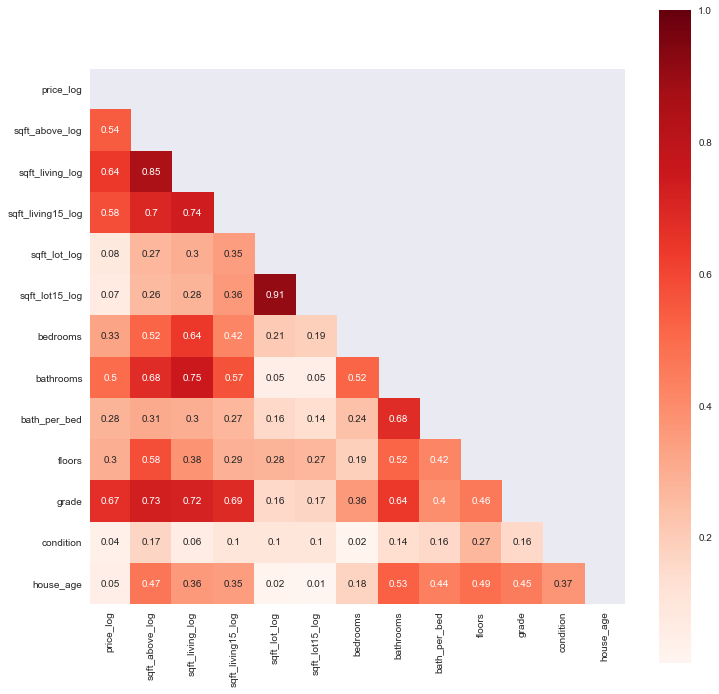

<Figure size 864x864 with 0 Axes>

In [31]:
heat_corr(zipcode_model, cont_vars)

### Our strategy for removing columns will be:
    
- For any columns that share a high collinearity with one another, remove the one that has a weaker relationship with price_log.

For our zipcode model, we end up removing sqft_lot15_log, sqft_living15_log, 'sqft_above_log, and bathrooms

In [32]:
zipcode_model.drop(['sqft_lot15_log', 'sqft_living15_log', 'bathrooms', 'sqft_above_log'], axis=1, inplace=True)



In [33]:
for item in ['sqft_lot15_log', 'sqft_living15_log', 'bathrooms', 'sqft_above_log']:
    cont_vars.remove(item)

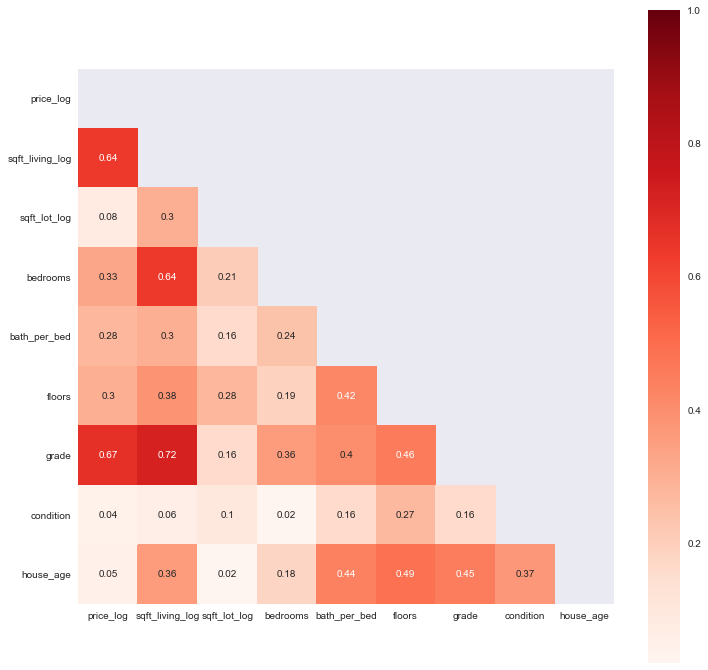

<Figure size 864x864 with 0 Axes>

In [34]:
heat_corr(zipcode_model, cont_vars)

We run through the same process above with our **subregion model.**

# Step 4 - Modeling

### Ordinary Least Squares

For this project, the linear model we are using to infer and predict housing prices comes from the statsmodels library:

**statsmodels.regression.linear_model.ols**

While not the strongest in terms of prediction, this model allows us to interpret which factors best determine our dependent variable given our independent variables. 

### Baseline Model

First we set the target **dependent variable('price_log')**, then we select the **predictors** we want to use in the model. We then feed these variables into our ols function along with our dataframe, and fit our model.

In [35]:
target = 'price_log'
predictors = zipcode_model.drop(['price', 'price_log'], axis=1).columns
preds = '+'.join(predictors)
f = target + '~' + preds
model = ols(formula=f, data=zipcode_model).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     1687.
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:57:53   Log-Likelihood:                -6490.4
No. Observations:               20027   AIC:                         1.314e+04
Df Residuals:                   19945   BIC:                         1.379e+04
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.9271      0.018    -50.903      0.000      -0.963      -0.891
sqft_living_log     0.3732      0.006     67.178      0.000       0.362       0.384
sqft_lot_log        0.0845      0.004     20.383      0.000       0.076       0.093
bedrooms            0.0044      0.004      0.996      0.319      -0.004       0.013
bath_per_bed        0.0337      0.004      8.592      0.000       0.026       0.041
floors             -0.0005      0.004     -0.135      0.893      -0.008       0.007
grade               0.2405      0.005     53.362      0.000       0.232       0.249
condition           0.0572      0.003     20.889      0.000       0.052       0.063
house_age           0.0199      0.004      4.685      0.000       0.012       0.028
waterfront          1.0500      0.036     28.881      0.000       0.979       1.121
renovated           0.1182      0.014      8.475      0.000       0.091       0.146
view                0.2989      0.009     32.299      0.000       0.281       0.317
has_basement       -0.0868      0.006    -13.398      0.000      -0.100      -0.074
zipcode_98002      -0.0275      0.030     -0.912      0.362      -0.087       0.032
zipcode_98003       0.0197      0.027      0.727      0.467      -0.033       0.073
zipcode_98004       2.1252      0.027     77.815      0.000       2.072       2.179
zipcode_98005       1.4147      0.032     43.571      0.000       1.351       1.478
zipcode_98006       1.2459      0.024     51.181      0.000       1.198       1.294
zipcode_98007       1.2347      0.034     36.280      0.000       1.168       1.301
zipcode_98008       1.2333      0.027     45.354      0.000       1.180       1.287
zipcode_98010       0.4396      0.042     10.450      0.000       0.357       0.522
zipcode_98011       0.8792      0.030     29.206      0.000       0.820       0.938
zipcode_98014       0.5422      0.041     13.081      0.000       0.461       0.623
zipcode_98019       0.6245      0.032     19.539      0.000       0.562       0.687
zipcode_98022       0.0246      0.031      0.791      0.429      -0.036       0.086
zipcode_98023      -0.0423      0.024     -1.797      0.072      -0.088       0.004
zipcode_98024       0.7686      0.057     13.562      0.000       0.658       0.880
zipcode_98027       1.0577      0.026     40.764      0.000       1.007       1.109
zipcode_98028       0.8039      0.027     29.821      0.000       0.751       0.857
zipcode_98029       1.1690      0.026     44.132      0.000       1.117       1.221
zipcode_98030       0.1029      0.028      3.699      0.000       0.048       0.157
zipcode_98031       0.1420      0.027      5.182      0.000       0.088       0.196
zipcode_98032      -0.0356      0.036     -1.003      0.316      -0.105       0.034
zipcode_98033       1.4987      0.024     61.183      0.000

Reading our model.summary(), we see that some of the predictor values are not significant for determining 'price_log'. Instead of manually removing the non-significant predictors, rerunning the model, and repeating the process, we create some functions that do all that for us.

In [36]:
def make_model(target, data, x_cols):
    """
    Definition:
    makes a model by using ols from statsmodels.formula.api
    
    Args:
    target = dependent variable
    data = selected dataframe
    x_cols = independent variables
    
    Returns:
    A model
    """
    preds = '+'.join(x_cols)
    f = target + '~' + preds
    model = ols(formula=f, data=data).fit()
    return model    

In [37]:
def loop_alphas(target, data, x_cols, n=5):
    """
    Definition:
    Runs through a loop n number of times, taking out predictor variables within the model.summary table
    that have p-values greater than 0.05. Returns the new model and model.summary
    
    Args:
    target = dependent variable
    data = selected Dataframe
    x_cols = independent variables
    n = number of times to run sequence
    
    Returns:
    The model and the summary
    """
    i = 1
    while i < n:
        model = make_model(target, data, x_cols)
        summary = make_model(target, data, x_cols).summary()
        p_table = summary.tables[1]
        p_table_df = pd.DataFrame(p_table.data)
        p_table_df.columns = p_table_df.iloc[0]
        p_table_df.drop(0, inplace=True)
        p_table_df.set_index(p_table_df.columns[0], inplace=True)
        p_table_df['P>|t|'] = p_table_df['P>|t|'].astype('float64')
        new_x_cols = list(p_table_df[p_table_df['P>|t|'] < 0.05].index)
        new_x_cols.remove('Intercept')
        x_cols = new_x_cols
        i += 1
#         print(len(new_x_cols), len(p_table_df))
    return model, summary

In [38]:
def qq_plot(model):
    """
    Definition:
    Creates a qq plot of the model's residuals to test for normality
    
    Args:
    model = selected model
    
    Returns:
    A graphed qq plot
    """
    resids = model.resid
    with plt.style.context('seaborn'):
        sm.graphics.qqplot(resids, stats.norm, line='45', fit=True);

In [39]:
def resid_scatter(model, target, data):
    """
    Definition:
    Plots a scatter plot to test model residuals for any obvious heteroscedasticity
    
    Args:
    model = selected model
    target = dependent variable
    data = selected DataFrame
    
    Returns:
    a graphed scatter plot comparing model residuals to target variable
    """
    resids = model.resid
    with plt.style.context('seaborn'):
        plt.scatter(data[target], resids);

In [40]:
def dist_resid(model):
    """
    Definition:
    plots a distribution plot of the model's residuals
    
    Args:
    model = selected model
    
    Returns:
    A graphed distplot of the residuals
    """
    resids = model.resid
    plt.figure(figsize=(8,5))
    sns.distplot(resids);

Using our new functions, we can easily run through these functions to remove insignificant values (variables that have a p-value > 0.05), use the qqplot to determine how normally distributed the data residuals are, use a scatterplot to see how the reisduals lay, and view the distribution of the residuals as well.

### Question 2: 
**Does a model perform better when we use zipcode as our location category or subregions as our location category?**

We want to know if there is any difference in strength between the zipcodes and subregions categories. This information woud allow us to see which model may be better to use. It could help homesellers by giving them a better understanding of why their home is priced the way it is. Also, if they intend to stay in King County it could give them an idea of the next zipcode/subregion they would like to live in given the price of houses in those areas.

In [41]:
model, summary = loop_alphas('price_log', zipcode_model, zipcode_model.drop(['price_log', 'price'], axis=1).columns)

In [42]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     1871.
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:58:59   Log-Likelihood:                -6497.5
No. Observations:               20027   AIC:                         1.314e+04
Df Residuals:                   19953   BIC:                         1.373e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.9340      0.008   -113.869      0.000      -0.950      -0.918
sqft_living_log     0.3766      0.004     90.475      0.000       0.368       0.385
sqft_lot_log        0.0849      0.004     21.615      0.000       0.077       0.093
bath_per_bed        0.0315      0.003     10.269      0.000       0.025       0.037
grade               0.2398      0.004     53.695      0.000       0.231       0.249
condition           0.0574      0.003     21.094      0.000       0.052       0.063
house_age           0.0187      0.004      4.581      0.000       0.011       0.027
waterfront          1.0474      0.036     28.839      0.000       0.976       1.119
renovated           0.1197      0.014      8.609      0.000       0.092       0.147
view                0.2994      0.009     32.425      0.000       0.281       0.318
has_basement       -0.0873      0.006    -15.352      0.000      -0.098      -0.076
zipcode_98004       2.1323      0.022     97.354      0.000       2.089       2.175
zipcode_98005       1.4222      0.028     50.643      0.000       1.367       1.477
zipcode_98006       1.2527      0.018     69.356      0.000       1.217       1.288
zipcode_98007       1.2426      0.030     41.600      0.000       1.184       1.301
zipcode_98008       1.2413      0.022     57.155      0.000       1.199       1.284
zipcode_98010       0.4451      0.039     11.446      0.000       0.369       0.521
zipcode_98011       0.8860      0.025     34.894      0.000       0.836       0.936
zipcode_98014       0.5474      0.038     14.311      0.000       0.472       0.622
zipcode_98019       0.6304      0.028     22.810      0.000       0.576       0.685
zipcode_98024       0.7752      0.054     14.260      0.000       0.669       0.882
zipcode_98027       1.0643      0.020     52.553      0.000       1.025       1.104
zipcode_98028       0.8107      0.022     37.591      0.000       0.768       0.853
zipcode_98029       1.1757      0.021     56.280      0.000       1.135       1.217
zipcode_98030       0.1098      0.023      4.843      0.000       0.065       0.154
zipcode_98031       0.1490      0.022      6.737      0.000       0.106       0.192
zipcode_98033       1.5054      0.018     82.178      0.000       1.470       1.541
zipcode_98034       1.0456      0.017     63.247      0.000       1.013       1.078
zipcode_98038       0.3323      0.017     19.921      0.000       0.300       0.365
zipcode_98039       2.4460      0.062     39.492      0.000       2.325       2.567
zipcode_98040       1.7020      0.023     74.435      0.000       1.657       1.747
zipcode_98042       0.1279      0.017      7.668      0.000       0.095       0.161
zipcode_98045       0.6137      0.026     23.526      0.000       0.563       0.665
zipcode_98052       1.2452      0.016     76.511      0.000

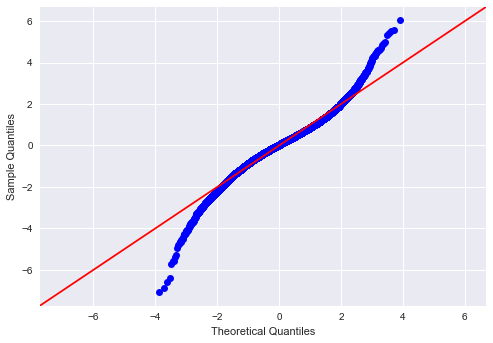

In [43]:
qq_plot(model)

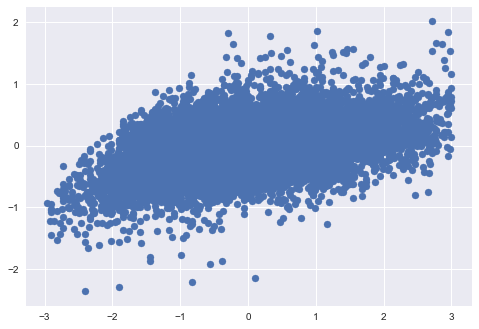

In [44]:
resid_scatter(model, 'price_log', zipcode_model)

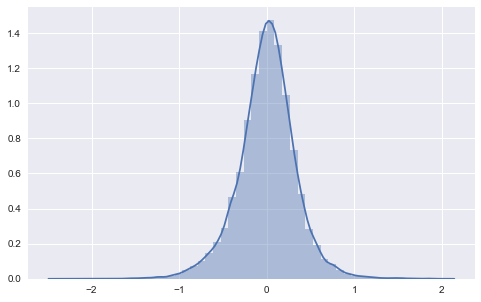

In [45]:
dist_resid(model)

Next, we need to make sure there is no multicollinearity within any of our columns, so we will create another function that uses variance inflation factor to find out if there are such columns in our model.

### VIF

In [46]:
def vif(df, non_target_cols):
    """
    Definition:
    Returns a list with each object in the list being the name of a column and it's variance inflation factor
    
    Args:
    df = selected dataframe
    non_target_cols = columns that are not independent variables
    """
    x_targets = df.drop(non_target_cols, axis=1)
    vif = [variance_inflation_factor(x_targets.values, i) for i in range(x_targets.shape[1])]
    return list(zip(x_targets, vif))

In [47]:
vif(zipcode_model, ['price', 'price_log'])

[('sqft_living_log', 4.972197986574189),
 ('sqft_lot_log', 2.3667472290482294),
 ('bedrooms', 2.8957244681030447),
 ('bath_per_bed', 2.4208232571921595),
 ('floors', 2.576384759447206),
 ('grade', 3.082980390946963),
 ('condition', 1.3145809460108067),
 ('house_age', 3.1460872492180276),
 ('waterfront', 1.1052866935761168),
 ('renovated', 1.1627623987045597),
 ('view', 1.3798812577545436),
 ('has_basement', 2.903060580740776),
 ('zipcode_98002', 1.0184760399520656),
 ('zipcode_98003', 1.0204509081439295),
 ('zipcode_98004', 1.0301140549082917),
 ('zipcode_98005', 1.0230110082012023),
 ('zipcode_98006', 1.0681157607136005),
 ('zipcode_98007', 1.0081316035207502),
 ('zipcode_98008', 1.0254336851311725),
 ('zipcode_98010', 1.0209745706432425),
 ('zipcode_98011', 1.0128319209601941),
 ('zipcode_98014', 1.0235505221452745),
 ('zipcode_98019', 1.0235164739723064),
 ('zipcode_98022', 1.0234838817121872),
 ('zipcode_98023', 1.0407327157144168),
 ('zipcode_98024', 1.0086103999123788),
 ('zipcod

As long as we don't see anything higher than 10, we should be relatively ok with this. Our last step for testing the zipcode model will be to validate it. We want to make sure it's a stable model.

### Cross Validation

In [48]:
linreg = LinearRegression()
X = zipcode_model.drop(['price', 'price_log'], axis=1)
y = zipcode_model[['price_log']]

In [49]:
cv_5_mse = np.mean(cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_squared_error'))
cv_10_mse = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_mse = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

cv_5_r_squared = np.mean(cross_val_score(linreg, X, y, cv=5, scoring='r2'))
cv_10_r_squared = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='r2'))
cv_20_r_squared = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='r2'))

In [50]:
print(f"CV 5 MSE: {cv_5_mse}\nCV 10 MSE: {cv_10_mse}\nCV 20 MSE: {cv_20_mse}"
      f"\n\nCV 5 R2: {cv_5_r_squared}\nCV 10 R2: {cv_10_r_squared}\nCV 20 R2: {cv_20_r_squared}")

CV 5 MSE: -0.1140227941738172
CV 10 MSE: -0.11388728959479921
CV 20 MSE: -0.11338189853840208

CV 5 R2: 0.8698312804889257
CV 10 R2: 0.8695018429732556
CV 20 R2: 0.8701195339865408


Based on the results of the cross validation, our model seems to be stable and isn't overfitted or underfitted.

### We repeat this process with our subregion model

In [51]:
#loading in subregion dataframe from our jupyter notebook
subregion_model = pd.read_csv('sub_model_final.csv', index_col='id')

In [52]:
subregion_model.head()

,price_log,sqft_living_log,sqft_living15_log,sqft_lot_log,bedrooms,bath_per_bed,floors,grade,condition,house_age,price,waterfront,renovated,view,has_basement,subregion_east_urban,subregion_north,subregion_north_and_seattle,subregion_seattle,subregion_south_and_seattle,subregion_south_rural,subregion_south_urban,subregion_vashon_island
id,,,,,,,,,,,,,,,,,,,,,,,
7129300520,-1.396379,-1.137533,-1.045715,-0.417664,-0.413282,-1.456963,-0.912126,-0.559105,-0.637969,0.531970,221900.0,0,0,0,0,0,0,0,0,0,0,1,0
6414100192,0.280619,0.707592,-0.335350,-0.109907,-0.413282,0.535990,0.966991,-0.559105,-0.637969,0.668363,538000.0,0,1,0,1,0,0,0,1,0,0,0,0
5631500400,-1.792645,-2.149421,1.121457,0.290145,-1.495317,-0.659782,-0.912126,-1.413864,-0.637969,1.282131,180000.0,0,0,0,0,0,1,0,0,0,0,0,0
2487200875,0.499734,0.065296,-1.000364,-0.569183,0.668754,0.535990,-0.912126,-0.559105,2.427758,0.190987,604000.0,0,0,0,1,0,0,0,1,0,0,0,0
1954400510,0.179413,-0.300108,-0.142320,0.025839,-0.413282,0.137399,-0.912126,0.295654,-0.637969,-0.559174,510000.0,0,0,0,0,1,0,0,0,0,0,0,0


In [53]:
sub_model, sub_summary = loop_alphas('price_log', subregion_model, subregion_model.drop(['price', 'price_log'], axis=1).columns)

In [54]:
sub_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     4253.
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:59:47   Log-Likelihood:                -10929.
No. Observations:               20027   AIC:                         2.190e+04
Df Residuals:                   20007   BIC:                         2.206e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.1494      0.016     -9.547      0.000      -0.180      -0.119
sqft_living_log                 0.3096      0.006     53.077      0.000       0.298       0.321
sqft_living15_log               0.1372      0.005     26.690      0.000       0.127       0.147
bath_per_bed                    0.0401      0.004     10.479      0.000       0.033       0.048
floors                          0.0215      0.004      4.971      0.000       0.013       0.030
grade                           0.2939      0.006     53.219      0.000       0.283       0.305
condition                       0.0744      0.003     22.346      0.000       0.068       0.081
house_age                       0.1269      0.005     26.805      0.000       0.118       0.136
waterfront                      0.9772      0.045     21.676      0.000       0.889       1.066
renovated                       0.1589      0.017      9.184      0.000       0.125       0.193
view                            0.2569      0.011     22.661      0.000       0.235       0.279
has_basement                   -0.0288      0.008     -3.718      0.000      -0.044      -0.014
subregion_east_urban            0.4128      0.017     24.841      0.000       0.380       0.445
subregion_north                 0.0857      0.020      4.322      0.000       0.047       0.125
subregion_north_and_seattle     0.1742      0.022      7.786      0.000       0.130       0.218
subregion_seattle               0.5203      0.018     29.346      0.000       0.486       0.555
subregion_south_and_seattle    -0.1830      0.030     -6.122      0.000      -0.242      -0.124
subregion_south_rural          -0.4371      0.021    -20.437      0.000      -0.479      -0.395
subregion_south_urban          -0.5518      0.017    -33.292      0.000      -0.584      -0.519
subregion_vashon_island        -0.1560      0.056     -2.769      0.006      -0.266      -0.046
==============================================================================
Omnibus:                      633.451   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1749.986
Skew:                           0.003   Prob(JB):                         0.00
Kurtosis:                       4.448   Cond. No.                         36.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

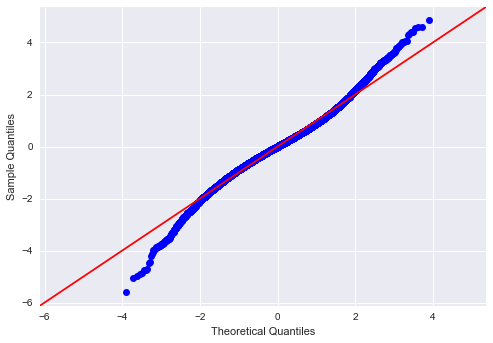

In [55]:
qq_plot(sub_model)

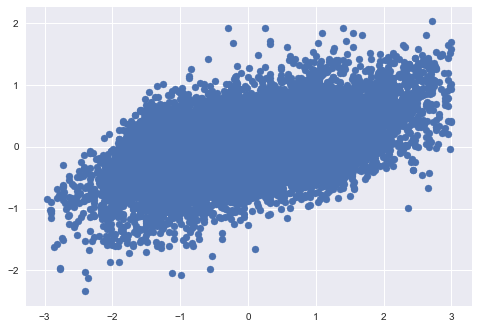

In [56]:
resid_scatter(sub_model, 'price_log', subregion_model)

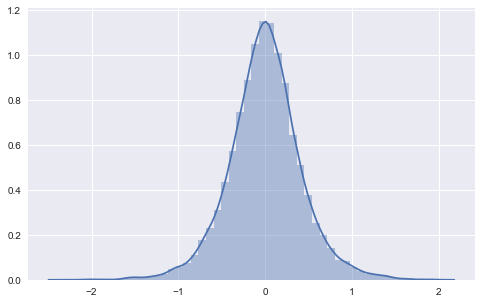

In [57]:
dist_resid(sub_model)

In [58]:
vif(subregion_model, ['price', 'price_log'])

[('sqft_living_log', 5.4924494622871185),
 ('sqft_living15_log', 2.8651390998984203),
 ('sqft_lot_log', 2.027555402890867),
 ('bedrooms', 2.8446848254289185),
 ('bath_per_bed', 2.3918016438820398),
 ('floors', 2.4478369319754627),
 ('grade', 2.9766043871070784),
 ('condition', 1.2594202008039639),
 ('house_age', 2.655715574107942),
 ('waterfront', 1.0966428397149965),
 ('renovated', 1.1528463146619523),
 ('view', 1.3325747755683244),
 ('has_basement', 2.784870639140419),
 ('subregion_east_urban', 1.3879021133656904),
 ('subregion_north', 1.0844176922310527),
 ('subregion_north_and_seattle', 1.0679672546483665),
 ('subregion_seattle', 2.5859599962922077),
 ('subregion_south_and_seattle', 1.037933464884607),
 ('subregion_south_rural', 1.068557309756816),
 ('subregion_south_urban', 1.318276591346026),
 ('subregion_vashon_island', 1.0603013716086513)]

In [59]:
linreg = LinearRegression()
X = subregion_model.drop(['price', 'price_log'], axis=1)
y = subregion_model[['price_log']]

In [60]:
cv_5_mse = np.mean(cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_squared_error'))
cv_10_mse = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_mse = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

cv_5_r_squared = np.mean(cross_val_score(linreg, X, y, cv=5, scoring='r2'))
cv_10_r_squared = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='r2'))
cv_20_r_squared = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='r2'))

In [61]:
print(f"CV 5 MSE: {cv_5_mse}\nCV 10 MSE: {cv_10_mse}\nCV 20 MSE: {cv_20_mse}"
      f"\n\nCV 5 R2: {cv_5_r_squared}\nCV 10 R2: {cv_10_r_squared}\nCV 20 R2: {cv_20_r_squared}")

CV 5 MSE: -0.17554311156652974
CV 10 MSE: -0.17547332856018602
CV 20 MSE: -0.17511437505069288

CV 5 R2: 0.7994721333240489
CV 10 R2: 0.7986499722631241
CV 20 R2: 0.7989679967633752


### Answer for Question 2:
**Does a model perform better when we use zipcode as our location category or subregions as our location category?**

After refining our **Zipcode Model** and our **Subregion Model**, we see that the most important factors when determining price is the location of the house. While some locations have a stronger relationship than price, some are also negatively related to price. It seems that from our subregion model, any southern subregion has a negative correlation to price. In terms of which model has a higher R squared value, we see that our zipcode model beats our subregions model with an 0.87 compared to our subregion model's R squared value of 0.80. 

However, our subregion model contains only 19 different variables, while our zipcode model contains 73. Our zipcode model is stronger, but our subregion model is easier to digest and interpret.

# Step 5 - Interpretation

### Question 3: 
**What are the most important factors under a homeowner's control when it comes to determining the price of a house in King County, WA?**

The answer for this question could help focus homeowners on the aspects of their house they can improve in order to increase the value of the home they are selling. Not only that, but it could also give them insight on which factors they do not necessarily need to worry about as much as others.

### Factors That Don't Hold Much Weight When Determining the Price of a Home:

- If a house has a basement
- The number of floors in a house
- Bathroom to bedroom ratio
- Condition of the house

### Important Factors a Homeseller CANNOT Control:
- Location
- if the house is considered a waterfront property
- the average sqft living area of the closest 15 neighbors
- Age of the house


### Answer for Question 3:

### Important Factors a Homeseller CAN Control:

- Grade of the House
- Renovation
- Sqft Living Area
- How many people view your house


## Recommendations

For homeowners looking to sell their King County, WA house:

- All important factors a homeowner can control are tied together. For example, if a homeowner hired a well reviewed licensed contractor to increase the sqft living area of their home through renovation using high quality materials, that would increase both the grade and sqft living area, which would increase the overall value of the house.


- As far as increasing views of a house, putting their house listing on multiple websites would attract attention, and hiring a professional photographer to maximize the attractiveness of their house and using those pictures could definitely help in terms of viewers. 